In [1]:

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0,1,2,3" # "0"
folder_name = 'figure'
os.makedirs(folder_name, exist_ok=True)
only_image = True

In [2]:
import torch
import numpy as np
import h5py
import cv2, PIL
import os, sys, gc
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2



In [3]:
img_len = 50
def load_img():
    noisy_arr, clean_arr = None, None
    set_num_list = ['SET01','SET02','SET03','SET04','SET05','SET06','SET07','SET08','SET09','SET10']
                
    dataset_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/test_Samsung_SNU_patches_SET01020304_divided_by_fnum_setnum.hdf5" 
    data_dict = h5py.File(dataset_path, "r")
    
    print("test wholedataset ",set_num_list)
    for set_num in set_num_list:
        set_num_idx = int(set_num[3:])
        noisy_f_num_list = ['F08','F16','F32','F64']   
        if set_num_idx >= 5 :
            dataset_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/test_Samsung_SNU_patches_SET050607080910_divided_by_fnum_setnum.hdf5"
            data_dict = h5py.File(dataset_path, "r")
            noisy_f_num_list = ['F01', 'F02', 'F04'] + noisy_f_num_list
        for f_num in noisy_f_num_list:
            if noisy_arr is None:
                noisy_arr = data_dict[set_num][f_num][:img_len]
                clean_arr = data_dict[set_num]['F64'][:img_len]
            else:
                noisy_arr = np.concatenate((noisy_arr, data_dict[set_num][f_num][:img_len]),axis=0)
                clean_arr = np.concatenate((clean_arr, data_dict[set_num]['F64'][:img_len]),axis=0)
        print(f'===Te loader {set_num} {noisy_f_num_list}===')
        print(f'{noisy_arr.shape[0]}/{clean_arr.shape[0]}  images are loaded')
    return noisy_arr, clean_arr

noisy_arr, clean_arr = load_img()
print("========= noisy,clean shape ==========")
print(noisy_arr.shape, clean_arr.shape)

test wholedataset  ['SET01', 'SET02', 'SET03', 'SET04', 'SET05', 'SET06', 'SET07', 'SET08', 'SET09', 'SET10']
===Te loader SET01 ['F08', 'F16', 'F32', 'F64']===
200/200  images are loaded
===Te loader SET02 ['F08', 'F16', 'F32', 'F64']===
400/400  images are loaded
===Te loader SET03 ['F08', 'F16', 'F32', 'F64']===
600/600  images are loaded
===Te loader SET04 ['F08', 'F16', 'F32', 'F64']===
800/800  images are loaded
===Te loader SET05 ['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64']===
1150/1150  images are loaded
===Te loader SET06 ['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64']===
1500/1500  images are loaded
===Te loader SET07 ['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64']===
1850/1850  images are loaded
===Te loader SET08 ['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64']===
2200/2200  images are loaded
===Te loader SET09 ['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64']===
2550/2550  images are loaded
===Te loader SET10 ['F01', 'F02', 'F04', 'F08', 'F16', 'F32', 'F64']===
2

In [4]:

name_sequence = []
for i in range(1,11):
    set_num = f"SET{i:02d}_"
    if i < 5:
        f_num_list = map(lambda x : f"{set_num}{x}",['F08', 'F16', 'F32','F64'])
    else :
        f_num_list = map(lambda x : f"{set_num}{x}",['F01', 'F02', 'F04', 'F08', 'F16', 'F32','F64'])
    name_sequence += f_num_list
print("========= name_sequence ==========")
print(name_sequence)
def map_image_name_to_index(set_num : str, f_num : str):
    name_to_index = {name : [i*img_len,(i+1)*img_len] for i, name in enumerate(name_sequence)}
    return name_to_index[f"{set_num}_{f_num}"]

========= name_sequence ==========
['SET01_F08', 'SET01_F16', 'SET01_F32', 'SET01_F64', 'SET02_F08', 'SET02_F16', 'SET02_F32', 'SET02_F64', 'SET03_F08', 'SET03_F16', 'SET03_F32', 'SET03_F64', 'SET04_F08', 'SET04_F16', 'SET04_F32', 'SET04_F64', 'SET05_F01', 'SET05_F02', 'SET05_F04', 'SET05_F08', 'SET05_F16', 'SET05_F32', 'SET05_F64', 'SET06_F01', 'SET06_F02', 'SET06_F04', 'SET06_F08', 'SET06_F16', 'SET06_F32', 'SET06_F64', 'SET07_F01', 'SET07_F02', 'SET07_F04', 'SET07_F08', 'SET07_F16', 'SET07_F32', 'SET07_F64', 'SET08_F01', 'SET08_F02', 'SET08_F04', 'SET08_F08', 'SET08_F16', 'SET08_F32', 'SET08_F64', 'SET09_F01', 'SET09_F02', 'SET09_F04', 'SET09_F08', 'SET09_F16', 'SET09_F32', 'SET09_F64', 'SET10_F01', 'SET10_F02', 'SET10_F04', 'SET10_F08', 'SET10_F16', 'SET10_F32', 'SET10_F64']


In [10]:
set_num_list = ['SET06']
print(set_num_list)
for set_num in set_num_list:

    index = map_image_name_to_index(set_num,'F01')
    noisy_images = noisy_arr[index[0]:index[1]]
    clean_index = map_image_name_to_index(set_num,'F64')
    clean_images = noisy_arr[clean_index[0]:clean_index[1]]
    F32_index = map_image_name_to_index(set_num,'F32')
    F32_images = noisy_arr[F32_index[0]:F32_index[1]]
    print(index, clean_index,clean_images.shape,noisy_images.shape)
    for idx in range(img_len):
        noisy_img,clean_img = noisy_images[idx],clean_images[idx]
        F32_img = F32_images[idx]
        filename = 'F01.eps'
        medianfilterd_img = apply_median_filter_gpu_simple(noisy_img)[0][0]
        noisy_img = PIL.Image.fromarray((noisy_img*255).astype('uint8'))
        noisy_img.save(f"{folder_name}/{filename}",dpi=(300,300),mode='eps')
        filename = 'median_filter_F01.eps'
        medianfilterd_img = PIL.Image.fromarray((medianfilterd_img*255).astype('uint8'))
        medianfilterd_img.save(f"{folder_name}/{filename}",dpi=(300,300),mode='eps')
        
        filename = 'F64.eps'
        clean_img = PIL.Image.fromarray((clean_img*255).astype('uint8'))
        clean_img.save(f"{folder_name}/{filename}",dpi=(300,300),mode='EPS')
        filename = 'F32.eps'
        medianfilterd_img = apply_median_filter_gpu_simple(F32_img)[0][0]
        F32_img = PIL.Image.fromarray((F32_img*255).astype('uint8'))
        F32_img.save(f"{folder_name}/{filename}",dpi=(300,300),mode='EPS')
        filename = 'median_filter_F32.eps'
        medianfilterd_img = PIL.Image.fromarray((medianfilterd_img*255).astype('uint8'))
        medianfilterd_img.save(f"{folder_name}/{filename}",dpi=(300,300),mode='eps')
        break

['SET06']
[1150, 1200] [1450, 1500] (50, 256, 256) (50, 256, 256)


In [18]:

args = get_args(env='colab')
args.pge_weight_dir = None #pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False

In [19]:
!date
!ls -alh ../weights/23*x_as_F01*F32*

Mon Sep 11 08:16:31 UTC 2023
-rw-rw-r-- 1 hyunwoong hyunwoong 3.2M Mar 30 22:41 ../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
-rw-rw-r-- 1 hyunwoong hyunwoong 3.2M May 23 22:33 ../weights/230521_find_lambda_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F32_l1_on_img_gradient_0.005_MSE_Affine_with_tv_layers_x17_filters_x64_cropsize_256.w


In [20]:

import itertools
def get_fbi_weight(f_num_list = ['F#','F01','F02','F04','F08','F16','F32','F64'],loss = 'MSE_Affine',filter_keyword = ['median']):
    comb = list(itertools.combinations(f_num_list,2))
    total_fbi_weight_list = []
    for x_f_num,y_f_num in comb:
        fbi_weight_list = glob(f"../weights/230*_FBI_Net*x_as_{x_f_num}*y_as_{y_f_num}*{loss}*")
        for keyword in filter_keyword:
            fbi_weight_list = list(filter(lambda x : keyword not in x,fbi_weight_list))
        total_fbi_weight_list += sorted(list(fbi_weight_list))
        print(x_f_num,y_f_num)
        for fbi_weight in fbi_weight_list:
            print(fbi_weight)
    return total_fbi_weight_list

In [21]:
gc.collect()
debug= True
target_fbi_weight = [
    "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F02_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F04_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F04_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230407_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F64_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    '../weights/230407_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F64_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
    # "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w"
    # "../weights/230407_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F64_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F04_MSE_Affine_layers_x17_filters_x64_cropsize_256.w"
]


In [22]:


def parsing_weight_name(fbi_weight_dir):
    target_y = fbi_weight_dir.split("_y_as_")[1][:3]
    if "x_as_" in fbi_weight_dir:
        target_x = fbi_weight_dir.split("x_as_")[1][:3]
        if 'F#' in target_x:
            target_x = "F#"
    else :
        target_x = "F#"
    dataset_version = 'v1' if 'with_SET01020304' in fbi_weight_dir else 'v2'
    if "l1_on_img_gradient" in fbi_weight_dir:
        lambda_val = fbi_weight_dir.split("l1_on_img_gradient_")[1].split("_")[0]
        dataset_version += f"_l1_on_img_gradient_{lambda_val}"
    return target_x,target_y, dataset_version


In [23]:

metric = {}

========= F01-F02 =========
['SET06']
[1150, 1200] [1450, 1500] (50, 256, 256) (50, 256, 256)


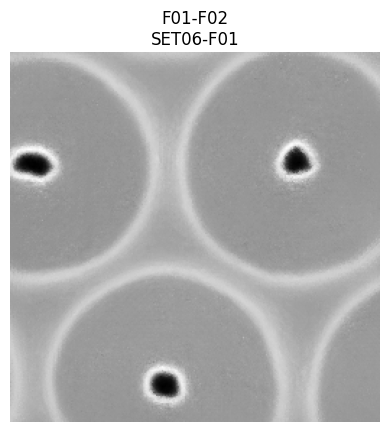

imwrite :  figure/F01-F02.tif
Denoising SET : SET06, f_num : F01 End
========= F#-F04 =========
['SET06']
[1150, 1200] [1450, 1500] (50, 256, 256) (50, 256, 256)


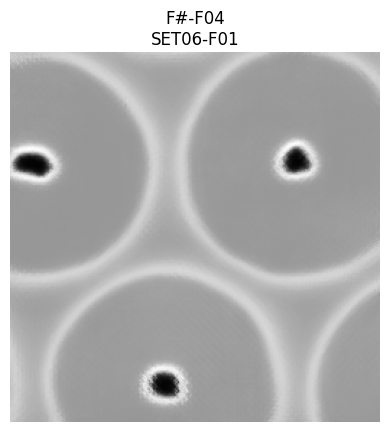

imwrite :  figure/F#-F04.tif
Denoising SET : SET06, f_num : F01 End
========= F01-F08 =========
['SET06']
[1150, 1200] [1450, 1500] (50, 256, 256) (50, 256, 256)


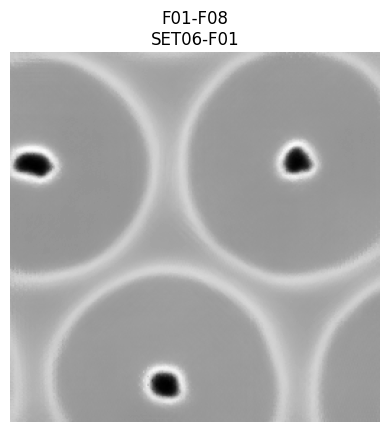

imwrite :  figure/F01-F08.tif
Denoising SET : SET06, f_num : F01 End
========= F#-F64 =========
['SET06']
[1150, 1200] [1450, 1500] (50, 256, 256) (50, 256, 256)


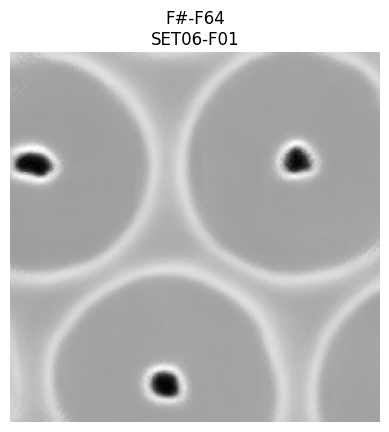

imwrite :  figure/F#-F64.tif
Denoising SET : SET06, f_num : F01 End


In [24]:
from core.utils import get_PSNR,get_SSIM


    
debug = False
imshow = False
for fbi_weight_dir in target_fbi_weight:

    target_x,target_y, dataset_version = parsing_weight_name(fbi_weight_dir)
    if debug is True:
        print(fbi_weight_dir)
        # print(median_filter_input,"median_filter_input")
    # key = f"{target_x}-{target_y}_{dataset_version}"
    key = f"{target_x}-{target_y}"
    os.makedirs(key,exist_ok=True)
    print(f"========= {key} =========")
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)
    
    # DENOISE IMAGE
    if target_x == 'F#':
        f_num = 'F01'
    else :
        f_num = target_x
        
    set_num_list = ['SET06']#
    
    metric[key] = {'before_PSNR' : [],
            'before_SSIM' : [],
            'PSNR' : [],
            'SSIM' : [],
            'median_PSNR' : [],
            'median_SSIM' : []}
    print(set_num_list)
    for set_num in set_num_list:
    
        index = map_image_name_to_index(set_num,f_num)
        noisy_images = noisy_arr[index[0]:index[1]]
        clean_index = map_image_name_to_index(set_num,'F64')
        clean_images = noisy_arr[clean_index[0]:clean_index[1]]
        print(index, clean_index,clean_images.shape,noisy_images.shape)
        for idx in range(img_len):
            noisy_img,clean_img = noisy_images[idx],clean_images[idx]
                # print(idx,noisy_img.shape, clean_img.shape)
                
            img = np.expand_dims(noisy_img,0)
            img = np.expand_dims(img,0)
            denoised_img = model.eval(img)[0][0]
            
                # print(img.shape, denoised_img.shape)
            before_psnr, before_ssim = get_PSNR(clean_img,noisy_img),get_SSIM(clean_img,noisy_img)
            psnr,ssim = get_PSNR(clean_img,denoised_img),get_SSIM(clean_img,denoised_img)
            
            # F32_img = noisy_arr[median_index[0]:median_index[1]][idx]
            # medianfilterd_img = apply_median_filter_gpu_simple(F32_img)[0][0]
            medianfilterd_img = apply_median_filter_gpu_simple(noisy_img)[0][0]
            median_psnr,median_ssim = get_PSNR(clean_img,medianfilterd_img),get_SSIM(clean_img,medianfilterd_img)
            metric[key]['PSNR'].append(psnr)
            metric[key]['SSIM'].append(ssim)
            metric[key]['before_PSNR'].append(before_psnr)
            metric[key]['before_SSIM'].append(before_ssim)
            # metric[key]['median_PSNR'].append(median_psnr)
            # metric[key]['median_SSIM'].append(median_ssim)
        
            if idx == 0:
                plt.box(False)
                plt.axis('off')
                plt.title(f"{key}\n{set_num}-{f_num}")
                plt.imshow(denoised_img,cmap='gray')
                plt.pause(0.01)
                filename = f"{key}.eps"
                print("imwrite : ",f"{folder_name}/{filename}")
                import PIL 
                denoised_img = PIL.Image.fromarray((denoised_img*255).astype('uint8'))
                denoised_img.save(f"{folder_name}/{filename}",dpi=(300,300),mode='EPS')
                # cv2.imwrite(f"{folder_name}/{filename}",denoised_img*255)
                if os.path.exists(f"{folder_name}/median.eps") is False:
                    filename = f"median.eps"
                    print("imwrite : ",f"{folder_name}/{filename}")
                    # cv2.imwrite(f"{folder_name}/{filename}",medianfilterd_img*255)
        
                    medianfilterd_img = PIL.Image.fromarray((medianfilterd_img*255).astype('uint8'))
                    medianfilterd_img.save(f"{folder_name}/{filename}",dpi=(300,300))
                if only_image is True:
                        break
        print(f"Denoising SET : {set_num}, f_num : {f_num} End")
            
        gc.collect()

    gc.collect()
    if debug is True:
        break


## EMSE_Affine

In [25]:

args = get_args(env='colab')
args.pge_weight_dir = '../weights/230831_PGE_Net_Grayscale_Samsung_SET050607080910_with_SET01020304_x_as_F01_y_as_F64_Noise_est_cropsize_256_vst_MSE.w'
args.loss_function = "EMSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False
target_fbi_weight = [
    # "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F02_MSE_Affine_layers_x17_filters_x64_cropsize_256.w"
    "../weights/230831_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F64_EMSE_Affine_layers_x17_filters_x64_cropsize_256.w"
]

========= F01-F64_EMSE_Affine =========
['SET06']
[1150, 1200] [1450, 1500] (50, 256, 256) (50, 256, 256)


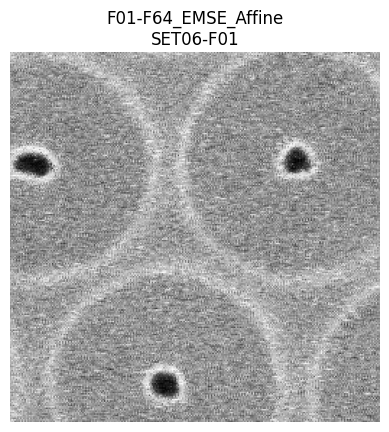

imwrite :  figure/F01-F64_EMSE_Affine.tif
imwrite :  figure/median_F01.tif
Denoising SET : SET06, f_num : F01 End


In [42]:
from core.utils import get_PSNR,get_SSIM


    
debug = False
imshow = False
for fbi_weight_dir in target_fbi_weight:

    target_x,target_y, dataset_version = parsing_weight_name(fbi_weight_dir)
    if debug is True:
        print(fbi_weight_dir)
        # print(median_filter_input,"median_filter_input")
    # key = f"{target_x}-{target_y}_{dataset_version}"
    key = f"{target_x}-{target_y}_EMSE_Affine"
    os.makedirs(key,exist_ok=True)
    print(f"========= {key} =========")
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)
    
    # DENOISE IMAGE
    if target_x == 'F#':
        f_num = 'F01'
    else :
        f_num = target_x
        
    set_num_list = ['SET06']#
    
    metric[key] = {'before_PSNR' : [],
            'before_SSIM' : [],
            'PSNR' : [],
            'SSIM' : [],
            'median_PSNR' : [],
            'median_SSIM' : []}
    print(set_num_list)
    for set_num in set_num_list:
    
        index = map_image_name_to_index(set_num,f_num)
        noisy_images = noisy_arr[index[0]:index[1]]
        clean_index = map_image_name_to_index(set_num,'F64')
        clean_images = noisy_arr[clean_index[0]:clean_index[1]]
        print(index, clean_index,clean_images.shape,noisy_images.shape)
        for idx in range(img_len):
            noisy_img,clean_img = noisy_images[idx],clean_images[idx]
                # print(idx,noisy_img.shape, clean_img.shape)
                
            img = np.expand_dims(noisy_img,0)
            img = np.expand_dims(img,0)
            denoised_img = model.eval(img)[0][0]
            
                # print(img.shape, denoised_img.shape)
            before_psnr, before_ssim = get_PSNR(clean_img,noisy_img),get_SSIM(clean_img,noisy_img)
            psnr,ssim = get_PSNR(clean_img,denoised_img),get_SSIM(clean_img,denoised_img)
            
            # F32_img = noisy_arr[median_index[0]:median_index[1]][idx]
            # medianfilterd_img = apply_median_filter_gpu_simple(F32_img)[0][0]
            medianfilterd_img = apply_median_filter_gpu_simple(noisy_img)[0][0]
            median_psnr,median_ssim = get_PSNR(clean_img,medianfilterd_img),get_SSIM(clean_img,medianfilterd_img)
            metric[key]['PSNR'].append(psnr)
            metric[key]['SSIM'].append(ssim)
            metric[key]['before_PSNR'].append(before_psnr)
            metric[key]['before_SSIM'].append(before_ssim)
            # metric[key]['median_PSNR'].append(median_psnr)
            # metric[key]['median_SSIM'].append(median_ssim)
        
            if idx == 0:
                plt.box(False)
                plt.axis('off')
                plt.title(f"{key}\n{set_num}-{f_num}")
                plt.imshow(denoised_img,cmap='gray')
                plt.pause(0.01)
                filename = f"{key}.eps"
                print("imwrite : ",f"{folder_name}/{filename}")
                import PIL 
                if type(denoised_img) == torch.Tensor:
                    denoised_img = denoised_img.cpu().numpy()
                denoised_img = PIL.Image.fromarray((denoised_img*255).astype('uint8'))
                denoised_img.save(f"{folder_name}/{filename}",dpi=(300,300),mode='eps')
                # cv2.imwrite(f"{folder_name}/{filename}",denoised_img*255)
                if os.path.exists(f"{folder_name}/median_F01.eps") is False:
                    filename = f"median_F01.eps"
                    print("imwrite : ",f"{folder_name}/{filename}")
                    # cv2.imwrite(f"{folder_name}/{filename}",medianfilterd_img*255)
        
                    medianfilterd_img = PIL.Image.fromarray((medianfilterd_img*255).astype('uint8'))
                    medianfilterd_img.save(f"{folder_name}/{filename}",dpi=(300,300))
                    noisy_img = PIL.Image.fromarray((noisy_img*255).astype('uint8'))
                    noisy_img.save(f"{folder_name}/F01.eps",dpi=(300,300))
                if os.path.exists(f"{folder_name}/median_F32.eps") is False:
                    # denoise F32 image
                    F32_index = map_image_name_to_index(set_num,'F32')
                    F32_images = noisy_arr[F32_index[0]:F32_index[1]]
                    F32_img = F32_images[idx]
    
                        
                    img = np.expand_dims(F32_img,0)
                    img = np.expand_dims(img,0)
                    medianfilterd_img = apply_median_filter_gpu_simple(img)[0][0]
                    
                    filename = f"median_F32.eps"
                    print("imwrite : ",f"{folder_name}/{filename}")
                    # cv2.imwrite(f"{folder_name}/{filename}",medianfilterd_img*255)
        
                    medianfilterd_img = PIL.Image.fromarray((medianfilterd_img*255).astype('uint8'))
                    medianfilterd_img.save(f"{folder_name}/{filename}",dpi=(300,300))
                    F32_img = PIL.Image.fromarray((F32_img*255).astype('uint8'))
                    F32_img.save(f"{folder_name}/F32.eps",dpi=(300,300))
                if only_image is True:
                        break
        print(f"Denoising SET : {set_num}, f_num : {f_num} End")
            
        gc.collect()

    gc.collect()
    if debug is True:
        break


## N2V

In [27]:

args = get_args(env='colab')
args.pge_weight_dir = None #'../weights/230831_PGE_Net_Grayscale_Samsung_SET050607080910_with_SET01020304_x_as_F01_y_as_F64_Noise_est_cropsize_256_vst_MSE.w'
args.loss_function = "N2V"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False
target_fbi_weight = [
    # "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F02_MSE_Affine_layers_x17_filters_x64_cropsize_256.w"
    "../weights/230702_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F64_N2V_layers_x17_filters_x64_cropsize_256.w"
]

========= F01-F64_N2V =========
['SET06']
[1150, 1200] [1450, 1500] (50, 256, 256) (50, 256, 256)


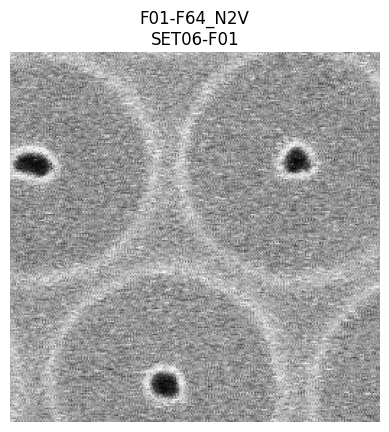

imwrite :  figure/F01-F64_N2V.tif
Denoising SET : SET06, f_num : F01 End


In [32]:
from core.utils import get_PSNR,get_SSIM


    
debug = False
imshow = False
for fbi_weight_dir in target_fbi_weight:

    target_x,target_y, dataset_version = parsing_weight_name(fbi_weight_dir)
    if debug is True:
        print(fbi_weight_dir)
        # print(median_filter_input,"median_filter_input")
    # key = f"{target_x}-{target_y}_{dataset_version}"
    key = f"{target_x}-{target_y}_N2V"
    os.makedirs(key,exist_ok=True)
    print(f"========= {key} =========")
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)
    
    # DENOISE IMAGE
    if target_x == 'F#':
        f_num = 'F01'
    else :
        f_num = target_x
        
    set_num_list = ['SET06']#
    
    metric[key] = {'before_PSNR' : [],
            'before_SSIM' : [],
            'PSNR' : [],
            'SSIM' : [],
            'median_PSNR' : [],
            'median_SSIM' : []}
    print(set_num_list)
    for set_num in set_num_list:
    
        index = map_image_name_to_index(set_num,f_num)
        noisy_images = noisy_arr[index[0]:index[1]]
        clean_index = map_image_name_to_index(set_num,'F64')
        clean_images = noisy_arr[clean_index[0]:clean_index[1]]
        print(index, clean_index,clean_images.shape,noisy_images.shape)
        for idx in range(img_len):
            noisy_img,clean_img = noisy_images[idx],clean_images[idx]
                # print(idx,noisy_img.shape, clean_img.shape)
                
            img = np.expand_dims(noisy_img,0)
            img = np.expand_dims(img,0)
            denoised_img = model.eval(img)[0][0]
            
                # print(img.shape, denoised_img.shape)
            before_psnr, before_ssim = get_PSNR(clean_img,noisy_img),get_SSIM(clean_img,noisy_img)
            psnr,ssim = get_PSNR(clean_img,denoised_img),get_SSIM(clean_img,denoised_img)
            
            # F32_img = noisy_arr[median_index[0]:median_index[1]][idx]
            # medianfilterd_img = apply_median_filter_gpu_simple(F32_img)[0][0]
            medianfilterd_img = apply_median_filter_gpu_simple(noisy_img)[0][0]
            median_psnr,median_ssim = get_PSNR(clean_img,medianfilterd_img),get_SSIM(clean_img,medianfilterd_img)
            metric[key]['PSNR'].append(psnr)
            metric[key]['SSIM'].append(ssim)
            metric[key]['before_PSNR'].append(before_psnr)
            metric[key]['before_SSIM'].append(before_ssim)
            # metric[key]['median_PSNR'].append(median_psnr)
            # metric[key]['median_SSIM'].append(median_ssim)
        
            if idx == 0:
                plt.box(False)
                plt.axis('off')
                plt.title(f"{key}\n{set_num}-{f_num}")
                plt.imshow(denoised_img,cmap='gray')
                plt.pause(0.01)
                filename = f"{key}.eps"
                print("imwrite : ",f"{folder_name}/{filename}")
                import PIL 
                denoised_img = denoised_img.cpu().numpy()
                denoised_img = PIL.Image.fromarray((denoised_img*255).astype('uint8'))
                denoised_img.save(f"{folder_name}/{filename}",dpi=(300,300),mode='eps')
                # cv2.imwrite(f"{folder_name}/{filename}",denoised_img*255)
                if os.path.exists(f"{folder_name}/median.eps") is False:
                    filename = f"median.eps"
                    print("imwrite : ",f"{folder_name}/{filename}")
                    # cv2.imwrite(f"{folder_name}/{filename}",medianfilterd_img*255)
        
                    medianfilterd_img = PIL.Image.fromarray((medianfilterd_img*255).astype('uint8'))
                    medianfilterd_img.save(f"{folder_name}/{filename}",dpi=(300,300))
                if only_image is True:
                        break
        print(f"Denoising SET : {set_num}, f_num : {f_num} End")
            
        gc.collect()

    gc.collect()
    if debug is True:
        break


In [ ]:
refined_metric = {}
for key in metric.keys():
    refined_metric[key] = {}
    for subkey in metric[key].keys():
        refined_metric[key][f"{subkey}_mean"] = np.mean(metric[key][subkey])
        refined_metric[key][f"{subkey}_std"] = np.std(metric[key][subkey])
import pandas as pd
                
    
pd_metric = pd.DataFrame(refined_metric)
if only_image is False:
    pd_metric.to_csv("metric_for_figure.csv")
pd_metric


""


In [ ]:
from knockknock import telegram_sender
@telegram_sender(token='1531143270:AAFTord-4Bi370ohc39wGyYhjGi7_VjZTwU', chat_id=1597147353)
def denoising_end():
    print("Denoising End")
denoising_end()
sys.exit(0)

Denoising End


SystemExit: 0

/mnt/ssd/hyun/fbi-net/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
